**2. Model validation playbook and automation** - we also have the BAML model validation playbook. This includes all of the necessary tests and expectations from model developers for an OLS model. We want to create a script to code these up. We will need to brief prior to starting. 
- Tree Based Model: validation playbook
 - Tree Building
    + Input Variables
        + Dropout / Switchout Test (GA - Feature Impact)*
        + Weight of evidence (WoE) 
        + Information Value 
    + Parameter Settings
        + Advanced Tuning Parameters (GA)
 - Accuracy Testing
    + ROC Curve (GA)
        + ROC Curve
        + Accuracy metrics (specificity, F1, etc)
    + Somers D
    + KS Test 
 - Performance Testing 
    + Out-of-sample Testing (validation, holdout)
    + Cross Validation (CV)
 - Error Attribution Analysis
 - NOT IN PLAYBOOK, but still could be useful
    + Lift chart (validation, holdout)
    + Prediction explanations
    + Model XRay



In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss, roc_curve, auc
from pprint import pprint
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from scipy import stats
import datarobot as dr
import os
import utils_ui, utils_stats, stress_test

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
datasets = ['train_housing_kaggle', 'DR_Demo_Fire_Ins_Loss_only', '10K_Lending_Club_Loans', '10kDiabetes']
targets  = ['Sale_Price', 'DELAY_INDICATOR', 'is_bad', 'readmitted']

DATASET_IDX = 3
SOURCE_DATA_FILE = 'data/' + datasets[DATASET_IDX] + '.csv'
TARGET = targets[DATASET_IDX]

# Read in data from .csv
df_full = pd.read_csv(SOURCE_DATA_FILE, encoding = "ISO-8859-1")

# Shuffle the rows
df_full = df_full.sample(frac=1, random_state=0)

# Split the data up - use 90% for training, 10% for test predictions
split = int(df_full.shape[0] * .1)
training_set = df_full[split:].reset_index(drop=True)
testing_set_with_target = df_full[:split].reset_index(drop=True)

# Drop the target from the prediction dataset
testing_set = testing_set_with_target.drop(TARGET, axis=1)

print('Full data shape:      ',df_full.shape)
print('Training data shape:  ',training_set.shape)
print('Testing data shape:   ',testing_set.shape)

Full data shape:       (10000, 52)
Training data shape:   (9000, 52)
Testing data shape:    (1000, 51)


In [3]:
#
# If you choose to use an existing completed project:
#

dr.Client(token=os.environ['DATAROBOT_API_TOKEN'], endpoint='https://app.datarobot.com/api/v2')
PROJECT_ID = '5b14846bb9a55268fbedee1c'
MODEL_ID = '5b1485d4f57686dbe56ccfff'

project = dr.Project.get(project_id=PROJECT_ID)
print('project.project_name:',project.project_name)
print('project.file_name:',project.file_name)
print('project.metric:',project.metric)
print('project.target:',project.target)
model = dr.Model.get(project=PROJECT_ID, model_id=MODEL_ID)
print('model.model_type:',model.model_type)

project.project_name: 10kDiabetes_classification_playbook
project.file_name: data.csv
project.metric: LogLoss
project.target: readmitted
model.model_type: eXtreme Gradient Boosted Trees Classifier with Early Stopping


In [4]:
#
# If you choose to train data for a new project:
#

# # Establish client connection
# dr.Client(token=os.environ['DATAROBOT_API_TOKEN'], endpoint='https://app.datarobot.com/api/v2')

# # Create a project: upload the data, set the target, give the project a name
# p_name = datasets[DATASET_IDX] + '_classification_playbook'
# project = dr.Project.create(sourcedata=training_set, 
#                             project_name=p_name)
# PROJECT_ID = project.id

# print('project id:  ', PROJECT_ID)
# print('project name:', project.project_name)
# print('project.get_status():\n- ', project.get_status())

# # By calling set_target, we run datarobot in the denoted mode
# # Blueprint processing and training will run asynchronously after performing the second EDA pass
# project.set_target(target=TARGET, 
#                    mode='auto',
#                    worker_count=20)

In [5]:
# # Get the models, which are already ordered by rank from the leaderboard
# models = project.get_models()

# # Get the best performing model (excluding the blenders, which are typically the top 4 models)
# for model in models:
#     if 'Blender' not in model.model_type:
#         best_model = model
#         break

# MODEL_ID = best_model.id
# print('Best model:', best_model.model_type)
# print('Best model id:', best_model.id)

In [6]:
# To get the training dataset cross validation folds from the original project, make a call to get a 
# model's training predictions.  The returned dataframe includes the project partition assignments.
predictions = stress_test.get_training_predictions(PROJECT_ID, MODEL_ID)
print(predictions.partition_id.value_counts())

predictions['y_true'] = training_set[project.target].astype(int)
print(predictions.shape,'\n')

predictions_v = predictions[predictions['partition_id'] == '0.0']
print('predictions validation:\n', predictions_v.head())
print(predictions_v.shape,'\n')

predictions_cv = predictions[predictions['partition_id'] != 'Holdout']
print('predictions cross validation:\n', predictions_cv.head())
print(predictions_cv.shape,'\n')

holdout = predictions[predictions['partition_id'] == 'Holdout']
print('predictions holdout:\n', holdout.head())
print(holdout.shape,'\n')

Training predictions are already requested and are ready.
- Time: 'get_training_predictions' 4.59
Holdout    1800
0.0        1440
2.0        1440
3.0        1440
1.0        1440
4.0        1440
Name: partition_id, dtype: int64
(9000, 6) 

predictions validation:
     row_id partition_id  prediction  class_1.0  class_0.0  y_true
1        1          0.0         0.0   0.439162   0.560838       0
2        2          0.0         0.0   0.389499   0.610501       0
4        4          0.0         1.0   0.578419   0.421581       1
8        8          0.0         0.0   0.470612   0.529388       1
11      11          0.0         0.0   0.224647   0.775353       1
(1440, 6) 

predictions cross validation:
    row_id partition_id  prediction  class_1.0  class_0.0  y_true
1       1          0.0         0.0   0.439162   0.560838       0
2       2          0.0         0.0   0.389499   0.610501       0
4       4          0.0         1.0   0.578419   0.421581       1
5       5          4.0         1.0   

In [7]:
# top_features = stress_test.get_model_top_features(PROJECT_ID, MODEL_ID, 10)
# top_features

# 1. Tree Building

Test Name | Description | Key Considerations
--- | --- | ---
Weight of Evidence (WoE) | Measures the strength of a set of categories across different values of the predictor variable to separate "good" and "bad" outcomes. | High negative or positive values are an indication of strong variable predictive power. While WoE allows inspection of the differentiation in odds across categories, the IV assesses the overall predictive power of the variable (see below).
Information Value (IV) | Assesses the overall power of a variable in separating "good" and "bad" outcomes by summing the product of WoE and the difference of "goods" and "bads" across all categories within the variable. | Higher IV levels indicate stronger relationship between the variable and the good/bad odds ratio. Can be used to compare predictive power among competing variables. Generally, an IV of less than 0.1 would be a cause of particular concern and should therefore be evaluated carefully taking into account the model context and other test results.
Dropout / Switchout Test | Drop or switch out a predictor variable from the model and compare the model fit and performance between the revised and the original models. | This test can help confirm that the chosen model has included the right predictor variables and no extraneous ones.


### Weight of Evidence (WOE) and Information Value (IV)::

In [8]:
cols = ['race', 'gender', 'age']
woe, iv = utils_stats.woe_iv(training_set[cols], training_set.readmitted)

Feature    WOE                                               IV
---------  ---------------------------------------  -----------
race       "?": -0.7275309274844175                 0.0231981
           "AfricanAmerican": -0.18693472542011916
           "Asian": -0.16943605238970158
           "Caucasian": 0.07869010345962997
           "Hispanic": -0.20498098980911295
           "Other": -0.20925754657637297
gender     "Female": 0.027852577422758706           0.000914135
           "Male": -0.03282299322777069
age        "[0-10)": -1.7143354436862306            0.0389792
           "[10-20)": -0.6056728191646193
           "[20-30)": -0.33268146212284216
           "[30-40)": -0.4350285925348959
           "[40-50)": -0.22137252224849832
           "[50-60)": -0.09140485120765615
           "[60-70)": 0.03618106700777519
           "[70-80)": 0.13329502739684754
           "[80-90)": 0.2035354853046898
           "[90-100)": -0.33600925221551675


### Dropout / Switchout Test:

Note about this being available in part within DataRobot to feature impact?  Alternatvely, forward or backward feature selection

In [9]:
# Forward or backward selection for dropout/switch out?

# 2. Accuracy Testing

Test Name | Description | Key Considerations
--- | --- | ---
Accuracy Rate | Accuracy is measured as the ratio of the number of correct predictions over the total number of predictions. | Confusion matrices can be constructed to identify false positives and false negatives.
Receiver Operating Characteristic (ROC) Curve | The ROC curve displays the tradeoff between sensitivity and specificity. The area under the ROC curve is a popular measure of discriminatory power. It is also often helpful to plot this curve for visual inspection. Gini coefficient and accuracy ratio are metrics derived from such curves. | A model with high discrimination ability will have an ROC curve which goes close to the top left corner of the plot. This leads to having the area under the curve (AUC) close to 1. A model with no discrimination ability will have an ROC curve, which is the 45-degree diagonal line.
Somers' D | Somers' D is calculated from the difference between the numbers of concordance and discordance pairs. | A value close to zero indicates a random model. A higher value (close to 1) indicates higher discriminatory power.
Kolmogorov - Smirnov (KS) Test | The KS test is used to test for differences between distribution functions and hence can be used to assess if the classification tree model discriminates between the two binary outcomes. | Higher values of the KS statistic correspond to higher levels of discriminatory power.

#### Performing on the training data.  Prediction data could be processed as well.

#### Calculate best F1 or grab via beautiful soup?

## ROC Curve plot, KS, and F1 from DataRobot - plus Accuracy and Somers' D using source data calculations
Note:  There may be a difference due to stacked predictions

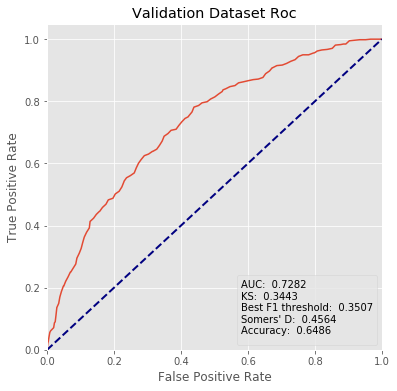

In [10]:
utils_ui.plot_roc_dr(model, dr.enums.CHART_DATA_SOURCE.VALIDATION, predictions_v)

### ROC Curve plot generated from source data (*note: slight differences in the ROC curve points from DR's):

Confusion matrix:
[[727 137]
 [319 257]]
Accuracy: 0.683 (984/1440)


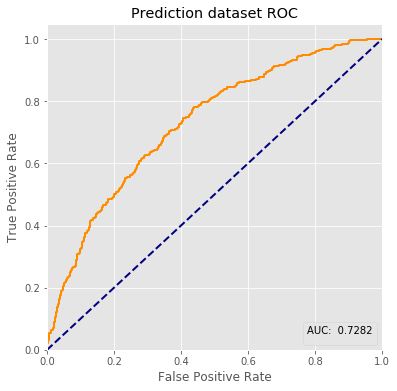

In [11]:
# predictions_v is the valdation set
# predictions_cv is the cross valdation set
y_true = predictions_v['y_true']
y_pred_1 = predictions_v['class_1.0']
y_pred_0 = predictions_v['class_0.0']

threshold = .5

# Confusion matrix, accuracy
print('Confusion matrix:')
cm = utils_stats.confusion_matrix_threshold(predictions_v, 'y_true', 'class_1.0', threshold)
print(cm)
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / predictions_v.shape[0]
print('Accuracy: %0.3f (%s/%s)' % (accuracy, (tp + tn), predictions_v.shape[0]))

# Plot the ROC curve
utils_ui.plot_roc(y_true, y_pred_1) 

### Somers' D from source dat:

In [12]:
# Two forms of calculating Somers' D:
utils_stats.somersd(score=y_pred_1, y_true=y_true, print_all=True)
print()
somersd = utils_stats.somersd_gini(score=y_pred_1, target=y_true)
print('Somers D as a Gini calculation (using bins): %0.3f' % somersd)

Pairs =  497664
Conc =   362394
Disc =   135270
Tied =   0
Concordance: 0.730
Discordance: 0.270
Tied:        0.000
-------------------
Somers D:    0.456

Somers D as a Gini calculation (using bins): 0.457


### Kolmogorov Smirnov from source data:
##### ***Question - Compare the pred true v pred false?  They are perfect compliments, not sure if that's what is asked for.

KS test: Ks_2sampResult(statistic=0.4534722222222222, pvalue=3.2106703904218673e-130)


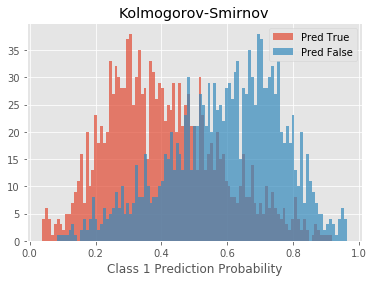

In [13]:
ks_result = utils_stats.ks(y_pred_1, y_pred_0)
print('KS test:', ks_result)

utils_ui.plot_ks(y_pred_1, y_pred_0)

# 3. Performance Testing - Out-of-sample Testing

Test Name | Description | Key Considerations
--- | --- | ---
Model Predictive Ability | Use the classification tree model to predict each record in the new data set and then calculate the following metrics: • Accuracy Rate • Somers' D • KS.  Compare the above metrics with those from the model based on training data and an alternate or existing model. | A significant drop in performance during out-ofsample testing can indicate that the model was over-fitted, key variables were omitted or the relationship established from the development data no longer holds due to structural changes.
Model Stability | Estimate the classification tree model using the testing data set and compare the following statistics to the model estimated using the training data set: • Accuracy Rate • Somers' D • KS.  A qualitative comparison of the tree structure (order, levels, nodes, etc.) can also be informative for model stability assessment. | Consistency between tree structure and performance statistics across data samples is an indication that the selected classification tree model is stable and applicable beyond data it has been trained on.

#### Test the classification tree model against new data to assess its stability and predictive ability. New data can either originate from a true hold-out sample (randomly selected and not used in development) or more recent data collected subsequent to the development of the model.

### Tests using holdout data:

In [14]:
project.holdout_unlocked

True

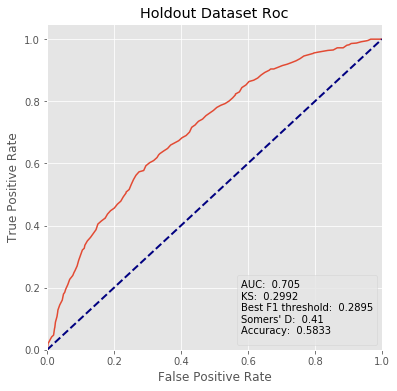

In [15]:
# Classification accuracy metrics for the holdout dataset:
# utils_ui.output_playbook_classification_accuracy(holdout, cm_thresh=.5)
utils_ui.plot_roc_dr(model, dr.enums.CHART_DATA_SOURCE.HOLDOUT, holdout)

### Tests using prediction data:

In [16]:
datasets = project.get_datasets()

# Upload the scoring dataset if not already uploaded, else retrieve it
if (len(datasets) == 0):
    print('Uploading prediction dataset')
    pred_ds = project.upload_dataset(testing_set)
else:
    print('Retrieving the prediction dataset id')
    for s in datasets:
        if s.name == 'predict.csv':
            pred_ds = s

# Request predictions for the scoring dataset, if it hasn't been already requested
try:                      
    predict_job
except NameError:
    print('Requesitng predictions')
    predict_job = model.request_predictions(pred_ds.id)
    
# Get the predictions results when complete
print('Waiting for prediction results')
test_preds = predict_job.get_result_when_complete()
print('- done.  Test predictions dataframe:')
print(test_preds.head())

# Add a column for the target labels (y_true)
test_preds['y_true'] = testing_set_with_target[TARGET].astype(int).tolist()
print('\n',test_preds.head())

Retrieving the prediction dataset id
Requesitng predictions
Waiting for prediction results
- done.  Test predictions dataframe:
   positive_probability  prediction  row_id  class_0.0  class_1.0
0              0.375409         0.0       0   0.624591   0.375409
1              0.558145         1.0       1   0.441855   0.558145
2              0.367415         0.0       2   0.632585   0.367415
3              0.712234         1.0       3   0.287766   0.712234
4              0.156801         0.0       4   0.843199   0.156801

    positive_probability  prediction  row_id  class_0.0  class_1.0  y_true
0              0.375409         0.0       0   0.624591   0.375409       0
1              0.558145         1.0       1   0.441855   0.558145       1
2              0.367415         0.0       2   0.632585   0.367415       1
3              0.712234         1.0       3   0.287766   0.712234       1
4              0.156801         0.0       4   0.843199   0.156801       0


### For new test predictions, need to calculate ROC and other metrics:

Confusion matrix:
[[526 108]
 [224 142]]
Accuracy: 0.668 (668/1000)
Somers' D: 0.381
KS: statistic=0.502, pvalue=4.274020779181605e-111


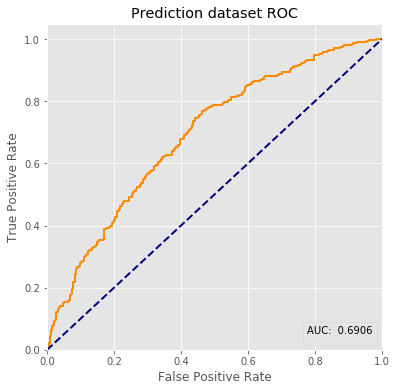

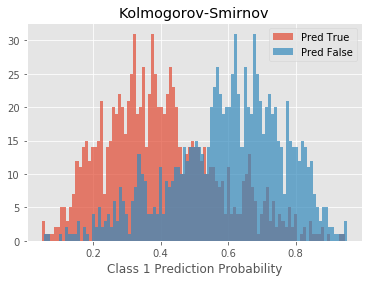

In [17]:
# Classification accuracy metrics for uploaded predictions:
utils_ui.output_playbook_classification_accuracy(test_preds, cm_thresh=.5)

# 3. Performance Testing - Cross Validation

Test Name | Description | Key Considerations
--- | --- | ---
Model Accuracy / Stability | Use the classification tree model estimated on the training data set to predict each case in the testing data set and then calculate the following metrics: • Accuracy Rate • Somers' D • KS Compare the above metrics with those from the model based on training data and an alternate or existing model. | A significant deterioration in model performance on testing data during cross validation could be an indication of overfitting and/or variable omission.
Model Stability | Estimate the classification tree model using the testing data set and compare the following statistics to the model estimated using the training data set: • Accuracy Rate • Somers' D • KS.  A qualitative comparison of the tree structure (order, levels, nodes, etc.) can also be informative for model stability assessment. | Consistency between tree structure and performance statistics across data samples is an indication that the selected classification tree model is stable and applicable beyond data it has been trained on.

#### In the case of insufficient out of sample data, test the classification tree model's stability and predictive ability by using cross validation. This is typically seen in cases where the overall data population available is small and the developer uses the entire population to develop the classification tree model.

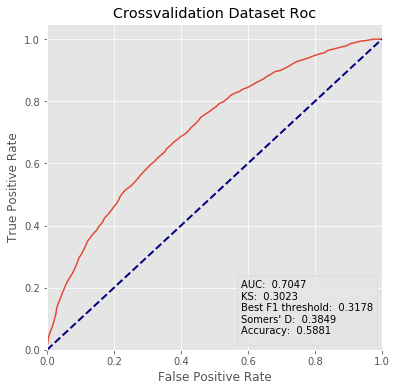

In [18]:
# Classification accuracy metrics for the cross valdation dataset:
# utils_ui.output_playbook_classification_accuracy(predictions_cv, cm_thresh=.5)
utils_ui.plot_roc_dr(model, dr.enums.CHART_DATA_SOURCE.CROSSVALIDATION, predictions_cv)

## NOT IN PLAYBOOK, but still could be useful
- Lift chart (validation, holdout)
- Prediction explanations
- Model XRay

### Lift Chart

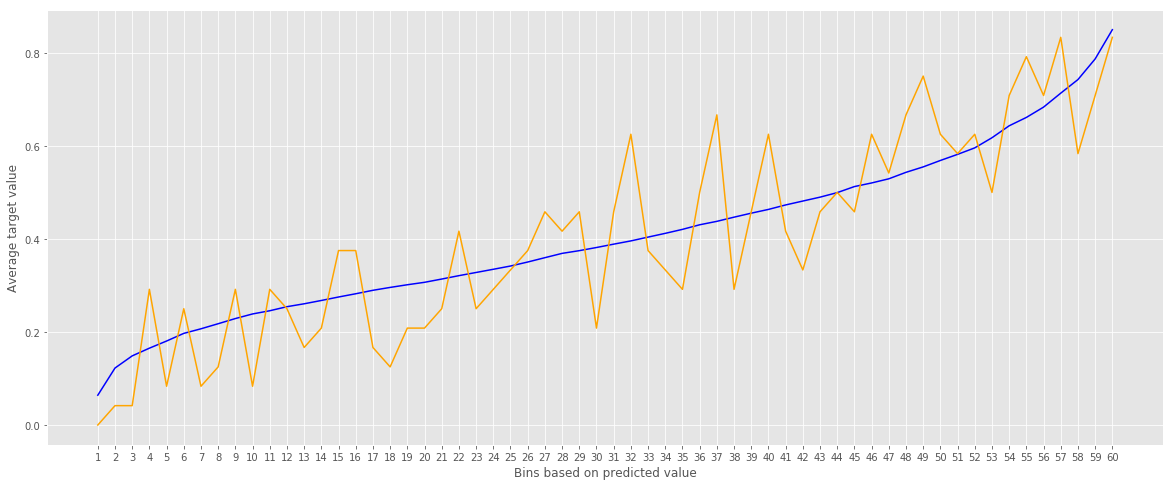

In [19]:
utils_ui.plot_lift_chart_dr(model, dr.enums.CHART_DATA_SOURCE.VALIDATION, 60)